Outline:
* Run 3 models: Logistic Regression, Random Forest, and Gradient Boosting Tree
* Generate ROC curves and AUC scores for each model and compare
* Generate a confustion matrix for the optimal model
* Segement predicted probabilites and observe how the AUC score varies across these segments
* Determine the top 10 most important features
* Investigate how certain features vary with transportation outcomes

Notes:
* Data are not displayed for data privacy reasons
* Hyperparameter tuning was performed separately, and the tuned parameters were inserted directly into the models when they were initialized

Importing data:

In [31]:
import pandas as pd

df = pd.read_csv('Cleaned_Data.csv')


Splitting independent variables from target variable:

In [6]:
X = df.drop(columns = ['transportation_issues'])
y = df['transportation_issues']


Investigating class distribution:

In [7]:
num_nti = y.value_counts()[0]
num_ti = y.value_counts()[1]
print(f'{num_nti / len(y) * 100:.2f}% without TI')
print(f'{num_ti / len(y) * 100:.2f}% with TI')


85.38% without TI
14.62% with TI


Initializing models:

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# initialize Logistic Regression model with pre-tuned hyperparameters
lr = LogisticRegression(C = 2.15, penalty = 'l1', solver = 'liblinear', random_state = 10)

# initialize Random Forest model with pre-tuned hyperparameters
rf = RandomForestClassifier(n_estimators=800, min_samples_split = 5,
                                         min_samples_leaf = 1, max_features = 'sqrt',
                                         max_depth = 110, bootstrap = False, random_state = 10)

# initialize Gradient Boosting Tree model with pre-tuned hyperparameters
gb = GradientBoostingClassifier(learning_rate=0.005, n_estimators=1500,
                                max_depth=5, min_samples_split=1200,min_samples_leaf=50,
                                subsample=0.8, max_features=13, random_state = 10)


Training classifiers and recording results:

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score

classifiers = [lr, rf, gb]
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, random_state = 2)

for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)
    

In [10]:
result_table # note that the Gradient Boosting Tree performs best


,classifiers,fpr,tpr,auc
0,LogisticRegression,"[0.0, 0.0, 0.0, 0.00020196580045778916, 0.0002...","[0.0, 0.00039494470774091627, 0.00118483412322...",0.733049
1,RandomForestClassifier,"[0.0, 0.0, 6.732193348592971e-05, 6.7321933485...","[0.0, 0.00039494470774091627, 0.00039494470774...",0.727751
2,GradientBoostingClassifier,"[0.0, 0.0, 6.732193348592971e-05, 6.7321933485...","[0.0, 0.00039494470774091627, 0.00039494470774...",0.747931


Plotting ROC curves:

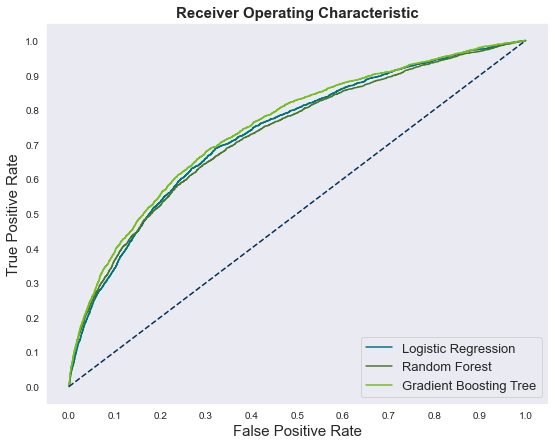

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_style('dark')
labels = ['Logistic Regression', 'Random Forest', 'Gradient Boosting Tree']
humana_colors = ['#007481', '#4B772A', '#78BE20']
fig = plt.figure(figsize=(9,7))

for i in range(len(result_table)):
    plt.plot(result_table.fpr[i], result_table.tpr[i], label = labels[i], color = humana_colors[i])
    
plt.plot([0,1], [0,1], color='#003058', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('Receiver Operating Characteristic', fontweight = 'bold', fontsize = 15)
plt.legend(prop={'size':13}, loc='lower right')

# plt.savefig('Final ROC Curve.png')
plt.show()


Generating confusion matrix for Gradient Boosting Tree:

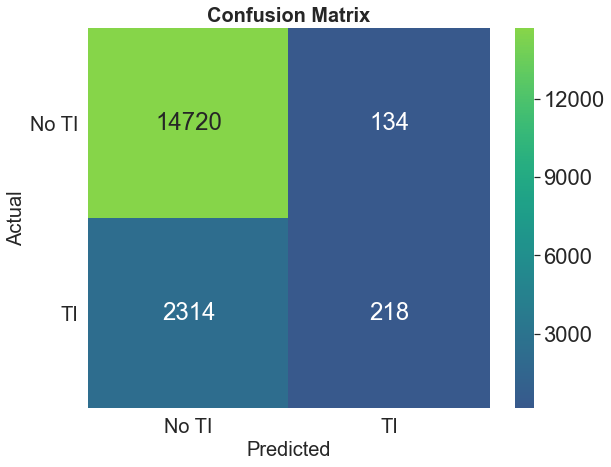

In [12]:
import matplotlib as mpl
from sklearn.metrics import confusion_matrix

# create custom Humana colormap by modifying mpl.cm.viridis
color_range = mpl.cm.viridis(np.arange(256))
cmap = mpl.colors.ListedColormap(color_range[70:210], name = 'Humana')

# generate confusion matrix
fig = plt.figure(figsize=(9,7))
predicted = gb.predict(X_test)
expected = y_test
confusion = confusion_matrix(y_true = expected, y_pred = predicted)
confusion_df = pd.DataFrame(confusion)
sns.set(font_scale=2.0)
axes = sns.heatmap(confusion_df, cmap = cmap, cbar_kws = {'ticks': [i for i in range(3000, 15000, 3000)]}, 
                   annot = True, fmt = 'g')
axes.set_xticklabels(['No TI', 'TI'], fontsize = 20)
axes.set_yticklabels(['No TI', 'TI'], fontsize = 20, rotation = 0)
axes.set_xlabel('Predicted', fontsize = 20)
axes.set_ylabel('Actual', fontsize = 20)
axes.set_title ('Confusion Matrix', fontsize = 20, fontweight = 'bold')
# plt.savefig('Final Confusion Matrix.png')
plt.show()


Exploratory analysis of probability distributions:

In [13]:
from statistics import mean, median, stdev

# redefine yproba and realated quantities with Gradient Boosting Tree predictions
model = gb.fit(X_train, y_train)
yproba = model.predict_proba(X_test)[::,1]
auc = roc_auc_score(y_test, yproba)

# exploratory analysis of the distribution of probabilities
print(f'Max: {max(yproba)}')
print(f'Min: {min(yproba)}')
print(f'Mean: {mean(yproba)}')
print(f'Median: {median(yproba)}')
print(f'Std. Deviation: {stdev(yproba)}')

# probabilities are concentrated at the lower end of the range
# to account for this, we'll segement the data into three groups with cutoffs at the 30th and 70th percentiles


Max: 0.7883171597778392
Min: 0.031429021727909616
Mean: 0.1456119284722657
Median: 0.1020347084127271
Std. Deviation: 0.11458755650092883


Segmenting probabilities and evaluating AUC scores for each segment:

In [14]:
from sklearn.metrics import roc_auc_score

# zip to keep probabilities with their respective labels
proba_with_labels = list(zip(yproba, y_test))

# segment proba/label tuples by probabilities
q30, q70 = np.percentile(yproba, [30, 70]) # compute cutoff values
yproba_high = [tup for tup in proba_with_labels if tup[0] >= q70]
yproba_med = [tup for tup in proba_with_labels if q30 <= tup[0] < q70]
yproba_low = [tup for tup in proba_with_labels if tup[0] < q30]

# unzip and calculate segmented auc scores
yproba_high, ylabel_high = list(zip(*yproba_high))
yproba_high_auc = roc_auc_score(ylabel_high, yproba_high)

yproba_med, ylabel_med = list(zip(*yproba_med))
yproba_med_auc = roc_auc_score(ylabel_med, yproba_med)

yproba_low, ylabel_low = list(zip(*yproba_low))
yproba_low_auc = roc_auc_score(ylabel_low, yproba_low)

print(yproba_high_auc)
print(yproba_med_auc)
print(yproba_low_auc)


0.652193376209889
0.5927465841624586
0.5401844947739417


Plotting segmented AUC scores:

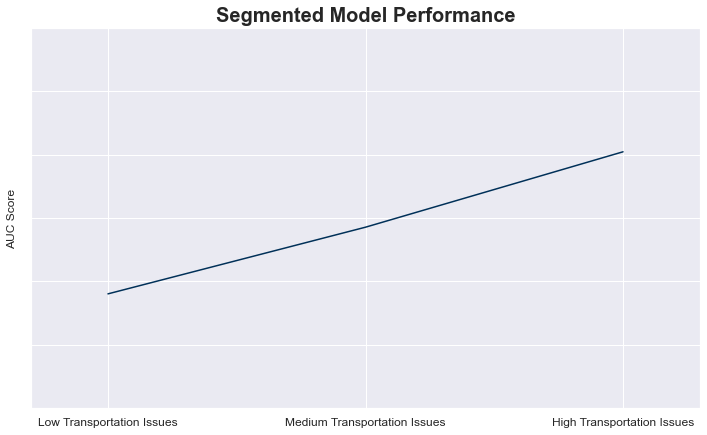

In [15]:
sns.set_style('darkgrid')

# define arrays
X = [1,2,3]
Y = [yproba_low_auc, yproba_med_auc, yproba_high_auc]

# figure formatting
fig = plt.figure(figsize = (12,7))
ax = sns.lineplot(X, Y, color = '#003058')
ax.set_xlim(0.7, 3.3)
ax.set_ylim([0.45, 0.75])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels(['Low Transportation Issues', 'Medium Transportation Issues',
                    'High Transportation Issues'], fontsize = 12)
ax.set_yticklabels([])
ax.set_ylabel('AUC Score', fontsize = 12)
ax.set_title('Segmented Model Performance', fontsize = 20, fontweight  = 'bold')
# plt.savefig('Final Segmented AUC Scores.png')
plt.show()


Evaluating feature importance:

In [16]:
import shap
sns.set_style('dark')

# reinitialize custom Humana colormap by modifying mpl.cm.viridis
color_range = mpl.cm.viridis(np.arange(256))
hum = mpl.colors.ListedColormap(color_range[70:210], name = 'Humana')

# compute feature importances
shap_values = shap.TreeExplainer(model).shap_values(X_train)


Renaming features with more interpretable labels:

In [17]:
to_rename = {
    'est_age': 'Age',
    'total_ambulance_visit_ct_pmpm': 'Total Ambulance Visits',
    'cms_low_income_ind': 'Low Income Indicator',
    'cms_rx_risk_score_nbr': 'Risk Score',
    'cms_disabled_ind': 'Disability Indicator',
    'cms_tot_ma_payment_amt': 'Total MA Payment',
    'cons_homstat_Y': 'Homeowner Indicator',
    'cms_dual_eligible_ind': 'Dual Eligibility Indicator',
    'cons_hhcomp_B': 'Household Composition',
    'betos_m5d_pmpm_ct': 'Specialist Visits'
}

temp = X_train.rename(columns = to_rename)


Plotting feature importance:

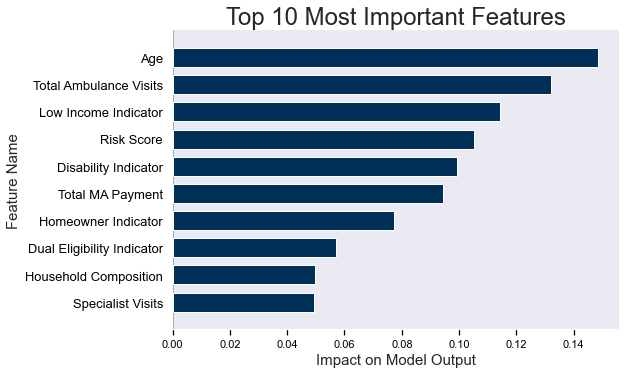

In [18]:
fig = shap.summary_plot(shap_values, features = temp, plot_type = "bar", max_display = 10, show = False,
                       axis_color = 'black', color = '#003058')
plt.title('Top 10 Most Important Features')
plt.xlabel('Impact on Model Output', fontsize = 15)
plt.ylabel('Feature Name', fontsize = 15)
# plt.savefig('Feature Importance.png')
plt.show()
 

Separating data by labels:

In [19]:
df_ti = df[df['transportation_issues'] == 1]
df_nti = df[df['transportation_issues'] == 0]
df_ti.reset_index(inplace = True)
df_nti.reset_index(inplace = True)


Investigating how income, disability status, and homeowner status vary with transportation outcomes:

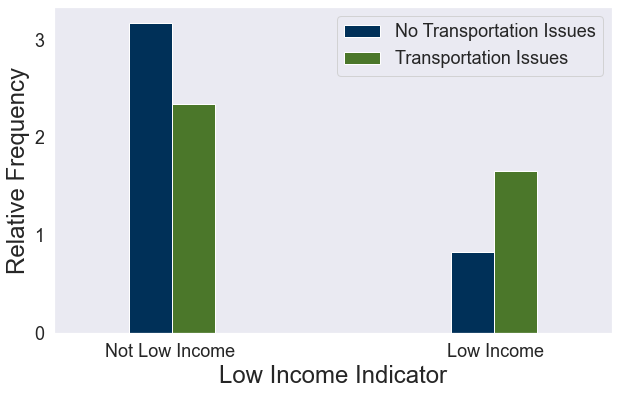

In [30]:
# hex codes for two Humana colors
humana_col = ['#003058', '#4B772A']

plt.figure(figsize = (10,6))
plt.hist([df_nti['cms_low_income_ind'], df_ti['cms_low_income_ind']],
         density = True, color = humana_col, bins = 4)
plt.xlabel('Low Income Indicator')
plt.ylabel('Relative Frequency')
plt.xticks([0.12, 0.88], labels = ['Not Low Income', 'Low Income'], fontsize = 18)
plt.yticks([0, 1, 2, 3], fontsize = 18)
plt.xlim(-0.15, 1.15)
plt.legend(labels = ['No Transportation Issues', 'Transportation Issues'], fontsize = 18)
# plt.savefig('Cohort Analysis - Income.png')
plt.show()


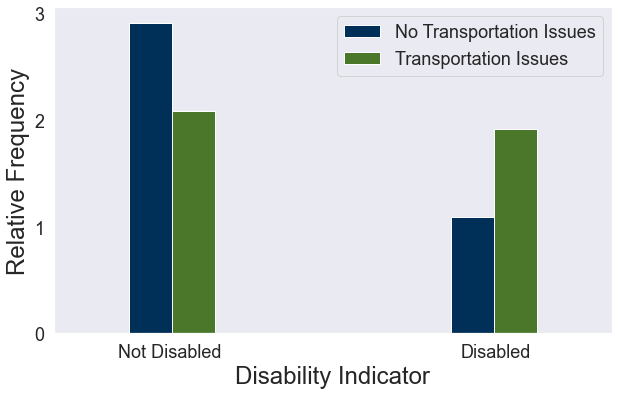

In [21]:
plt.figure(figsize = (10,6))
plt.hist([df_nti['cms_disabled_ind'], df_ti['cms_disabled_ind']],
         density = True, color = humana_col, bins = 4)
plt.xlabel('Disability Indicator')
plt.ylabel('Relative Frequency')
plt.xticks([0.12, 0.88], labels = ['Not Disabled', 'Disabled'], fontsize = 18)
plt.yticks([0, 1, 2, 3], fontsize = 18)
plt.xlim(-0.15, 1.15)
plt.legend(labels = ['No Transportation Issues', 'Transportation Issues'], fontsize = 18)
# plt.savefig('Cohort Analysis - Disability Status.png')
plt.show()


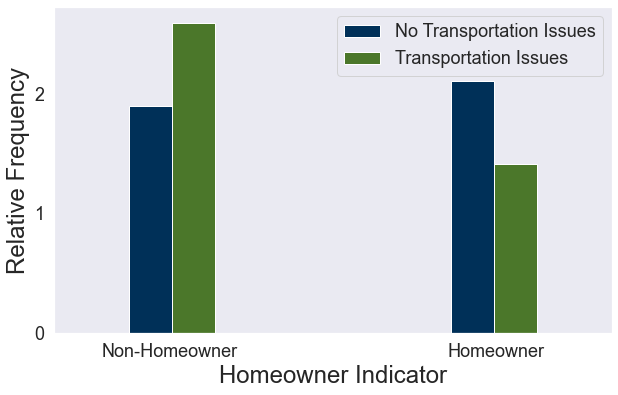

In [22]:
plt.figure(figsize = (10,6))
plt.hist([df_nti['cons_homstat_Y'], df_ti['cons_homstat_Y']],
         density = True, color = humana_col, bins = 4)
plt.xlabel('Homeowner Indicator')
plt.ylabel('Relative Frequency')
plt.xticks([0.12, 0.88], labels = ['Non-Homeowner', 'Homeowner'], fontsize = 18)
plt.yticks([0, 1, 2], fontsize = 18)
plt.xlim(-0.15, 1.15)
plt.legend(labels = ['No Transportation Issues', 'Transportation Issues'], fontsize = 18)
# plt.savefig('Cohort Analysis - Homeowner Status.png')
plt.show()
